# Super Learner

In practice, it is generally impossible to know a priori which learner will perform best for a given prediction problem and data set.

This involves selecting many different algorithms that may be appropriate for your regression or classification problem and evaluating their performance on your dataset using a resampling technique, such as k-fold cross-validation. 


The algorithm that performs the best on your dataset according to k-fold cross-validation is then selected, fit on all available data, and you can then start using it to make predictions.

Consider that you have already fit many different algorithms on your dataset, and some algorithms have been evaluated many times with different configurations. You may have many tens or hundreds of different models of your problem. Why not use all those models instead of the best model from the group?


This is the intuition behind the so-called “super learner” ensemble algorithm.

The super learner algorithm involves first pre-defining the k-fold split of your data, then evaluating all different algorithms and algorithm configurations on the same split of the data. All out-of-fold predictions are then kept and used to train an algorithm that learns how to best combine the predictions.

The results of this model should be no worse than the best performing model evaluated during k-fold cross-validation and has the likelihood of performing better than any single model.

The super learner technique is an example of the general method called “stacked generalization,” or “stacking”

We can think of the “super learner” as a specific configuration of stacking specifically to k-fold cross-validation.

The procedure can be summarized as follows:

    1. Select a k-fold split of the training dataset.
    2. Select m base-models or model configurations.
    3. For each basemodel:
        a. Evaluate using k-fold cross-validation.
        b. Store all out-of-fold predictions.
        c. Fit the model on the full training dataset and store.
    4. Fit a meta-model on the out-of-fold predictions.
    5. Evaluate the model on a holdout dataset or use model to make predictions.


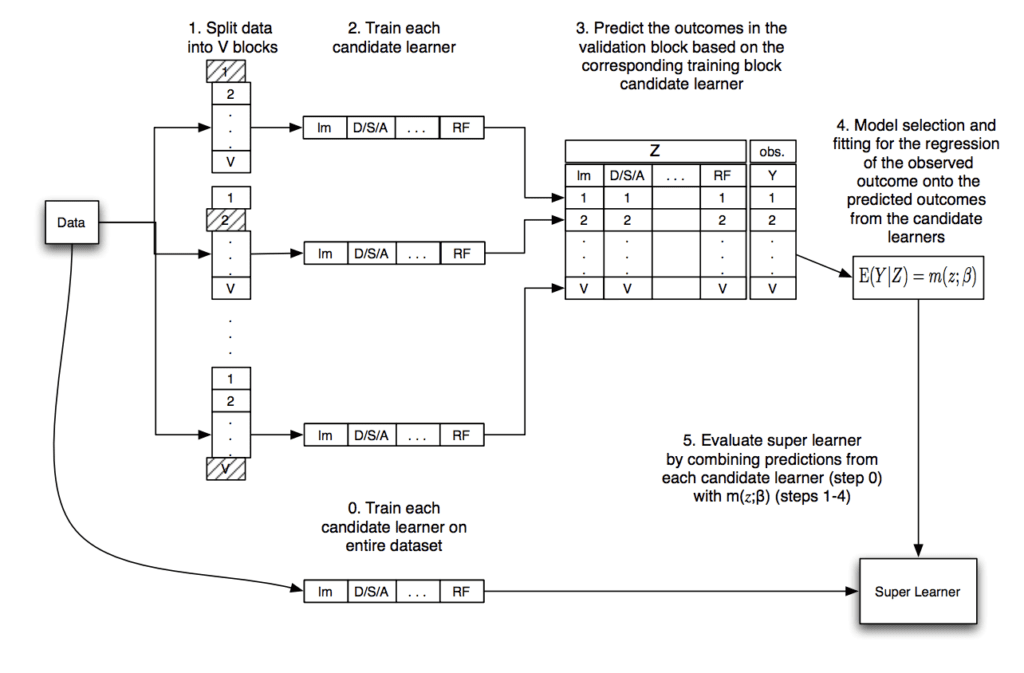

### What are the inputs and outputs for the meta-model?

The meta-model takes in predictions from base-models as input and predicts the target for the training dataset as output:

    Input: Predictions from base-models.
    Output: Prediction for training dataset.

For example, if we had 50 base-models, then one input sample would be a vector with 50 values, each value in the vector representing a prediction from one of the base-models for one sample of the training dataset.

If we had 1,000 examples (rows) in the training dataset and 50 models, then the input data for the meta-model would be 1,000 rows and 50 columns.

### Won’t the meta-model overfit the training data?

This is the trick of the super learner, and the stacked generalization procedure in general.

The input to the meta-model is the out-of-fold (out-of-sample) predictions. In aggregate, the out-of-fold predictions for a model represent the model’s skill or capability in making predictions on data not seen during training.

By training a meta-model on out-of-sample predictions of other models, the meta-model learns how to both correct the out-of-sample predictions for each model and to best combine the out-of-sample predictions from multiple models; actually, it does both tasks at the same time.

Importantly, to get an idea of the true capability of the meta-model, it must be evaluated on new out-of-sample data. That is, data not used to train the base models.

### Can this work for regression and classification?

It can work just as well for classification (predicting a class label), although it is probably best to predict probabilities to give the meta-model more granularity when combining predictions.

### Why do we fit each base-model on the entire training dataset?

Each base-model is fit on the entire training dataset so that the model can be used later to make predictions on new examples not seen during training.

This step is strictly not required until predictions are needed by the super learner.

###  How do we make a prediction?

To make a prediction on a new sample (row of data), first, the row of data is provided as input to each base model to generate a prediction from each model.

The predictions from the base-models are then concatenated into a vector and provided as input to the meta-model. The meta-model then makes a final prediction for the row of data.

We can summarize this procedure as follows:

    1. Take a sample not seen by the models during training.
    2. For each base-model:
        a. Make a prediction given the sample.
        b. Store prediction.
    3. Concatenate predictions from submodel into a single vector.
    4. Provide vector as input to the meta-model to make a final prediction.


When stacking several layers of base learners, the variance of the input will typically get smaller as learners get better and better at predicting the output and the remaining errors become increasingly difficult to correct for.

# Library

In [1]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import pandas as pd

In [13]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import model,scoring
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [39]:
# create the inputs and outputs
X, y = make_regression(n_samples=1000, n_features=100, noise=0.5)
# split
X, X_val, y, y_val = train_test_split(X, y+1000, test_size=0.50)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)

Train (500, 100) (500,) Test (500, 100) (500,)


# Super Learning Regression

In [41]:
models, meta_model, result = model.super_learner(X, y,['all'],types='regression',
                                                 val_size=0.3)

Origin size:  (500, 100) (500,)
Train size:  (350, 100) (350,)
Eval size:  (150, 100) (150,)
Meta size:  (350, 9) (350,)


In [42]:
result

,models name,scoring RMSE
0,Linear Regression,0.6206
1,Elastic Net,87.7368
2,K-Neighbors Regressor,182.8315
3,SVM Linear,205.7903
4,Decision Tree Regressor,202.2933
5,AdaBoost Regressor,131.8417
6,Bagging Regressor,143.6625
7,Random Forest Regressor,146.1804
8,Extra Trees Regressor,144.8245
9,Super Learner,0.6304


In [43]:
y_pred = model.super_learner_predictions(X_val, models, meta_model, 
                                                'regression')


Mean Absolute Percentage Error (MAPE) = 0.05 %
R2                                    = 100.0 %
Mean Absolute Error (MAE)             = 0.48
Median Absolute Error (MAE)           = 0.37
Mean Square Error (MSE)               = 0.38
Mean Square Log Error (MSLE)          = 0.0
Root Mean Absolute Error (RMAE)       = 0.69
Root Mean Absolute Error (RMSE)       = 0.62
Mean Absolute Scaled Error (MASE)     = 0.0
Max Error                             = 2.36
Explained Variance Score              = 1.0
Tracking Signal                       = [ 0.83 -0.85  0.76  1.11  1.61 -0.1   0.82 -1.41 -1.29 -2.01 -1.23  0.05
 -2.3   2.37 -0.92  0.4   0.7  -0.6   1.91 -0.32 -1.05  0.54  1.21 -0.3
  0.57 -0.55  0.61 -0.24  0.28  0.27 -0.24 -1.84 -0.41  1.23 -0.98  0.54
  1.13  0.55 -0.85  0.94 -1.43 -0.53 -0.43 -1.52 -1.61  2.75 -1.6  -0.06
  0.44 -0.01  0.67 -0.56 -1.78  0.81  0.   -0.86 -1.39  0.36 -0.36  0.52
  0.05 -1.74  0.58  0.26  1.68 -0.14 -1.16 -1.56 -0.14 -0.98 -0.43 -0.15
  1.41  0.24 -0.25 -0.03 

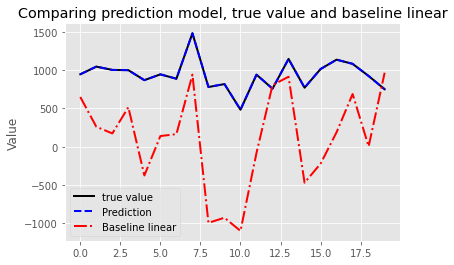


time span=  0


In [49]:
scoring.print_score(y_val,y_pred,y_probs=y_pred,
                    types='regression',labels=['0', '1'],
                    time1=0,time2=0,
                    X_train=X, y_train=y,X_test=X_val)

# Super Learning Classification

In [7]:
# create the inputs and outputs
X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)
# split
X, X_val, y, y_val = train_test_split(X, y, test_size=0.50)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)

Train (500, 100) (500,) Test (500, 100) (500,)


In [8]:
models, meta_model, result = model.super_learner(X, y,['all'],types='classification',
                                                 val_size=0.3)

Origin size:  (500, 100) (500,)
Train size:  (350, 100) (350,)
Eval size:  (150, 100) (150,)
Meta size:  (350, 18) (350,)


In [9]:
result

,models name,scoring Accuracy
0,Logistic Regression,0.9067
1,Naive Bayes,0.9267
2,K-Neighbors Classifier,0.8400
3,SVM Linear,0.9467
4,Decision Tree Classifier,0.6933
5,AdaBoost Classifier,0.9067
6,AdaBoost Classifier,0.8467
7,Random Forest Classifier,0.7600
8,Extra Trees Classifier,0.7600
9,Super Learner,0.9267


In [10]:
y_pred,y_prob = model.super_learner_predictions(X_val, models, meta_model, 
                                                'classification')

comfusion matrix = 
[[227   7]
 [ 20 246]]


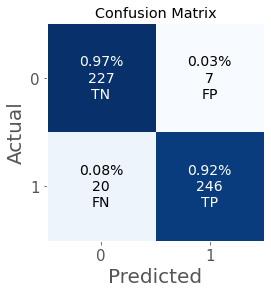


accuracy_score =  0.946
balanced_accuracy_score =  0.9474
Logloss =  0.1648

precision score =  0.9723
average precision score =  0.9392
recall score =  0.9248
Brier score loss (the smaller the better) =  0.0445

F1 score =  0.948
F2 score =  0.9339
F3 score =  0.9294
F_beta score (0.5) =  0.9624
Matthews Correlation Coefficient score =  0.8931

AUC of Precision-Recall Curve on Testing =  0.9903
Best Threshold for Precision-Recall Curve = 0.354000
F-Score = 0.956
AUC of ROC =  0.9873

Best Threshold for ROC = 0.354000
G-Mean = 0.955
Best Threshold with Youden’s J statistic = 0.354000

Cohens kappa =  0.8919
Gini =  0.9806

Expected Approval Rate =  0.506
Expected Default Rate =  0.0277

classification_report
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       234
           1       0.97      0.92      0.95       266

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted 

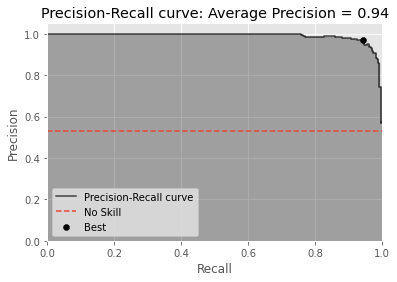

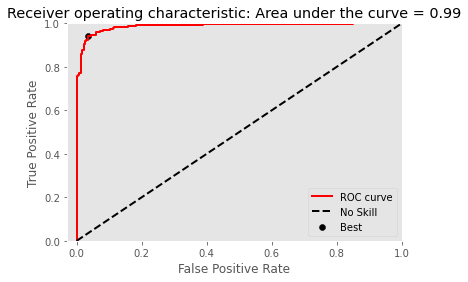


time span=  0


In [21]:
scoring.print_score(y_val,y_pred,y_probs=y_prob[:, 1],
                    types='classification',labels=['0', '1'],
                    time1=0,time2=0,
                    X_train=None, y_train=None,X_test=None)

# Super Learning mlens

In [50]:
X, y = make_regression(n_samples=1000, n_features=100, noise=0.5)

In [54]:
result,ensemble,models_name = model.sl_mlens(X,y,['all'],types='regression',
                                             kfolds=10,val_size=0.3,proba=False)

Origin size:  (1000, 100) (1000,)
Train size:  (700, 100) (700,)
Test size:  (300, 100) (300,)

Fitting 2 layers
Processing layer-1             done | 00:00:03
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:03
                                  score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  adaboostregressor          89.45     6.76  1.17  0.02  0.06  0.03
layer-1  baggingregressor          101.27     6.08  0.46  0.03  0.01  0.00
layer-1  decisiontreeregressor     145.13    12.14  0.08  0.01  0.00  0.00
layer-1  elasticnet                 64.33     5.41  0.01  0.00  0.00  0.00
layer-1  extratreesregressor        94.99     4.55  0.28  0.05  0.01  0.01
layer-1  kneighborsregressor       156.21    11.03  0.00  0.00  0.01  0.00
layer-1  linearregression            0.55     0.03  0.02  0.01  0.00  0.00
layer-1  randomforestregressor     100.84     8.99  0.46  0.03  0.00  0.00
layer-1  svr                       177.88    13.03  0.07  0.01  0.02  0

In [55]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)

In [58]:
result,ensemble,models_name = model.sl_mlens(X,y,['all'],types='classification',
                                             kfolds=10,val_size=0.3,proba=False)

Origin size:  (1000, 100) (1000,)
Train size:  (700, 100) (700,)
Test size:  (300, 100) (300,)

Fitting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:03
                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  adaboostclassifier           0.92     0.04  0.83  0.04  0.06  0.02
layer-1  baggingclassifier            0.84     0.06  0.40  0.01  0.01  0.01
layer-1  decisiontreeclassifier       0.71     0.04  0.06  0.00  0.00  0.00
layer-1  extratreesclassifier         0.82     0.03  0.12  0.02  0.01  0.01
layer-1  gaussiannb                   0.97     0.02  0.01  0.00  0.00  0.00
layer-1  kneighborsclassifier         0.94     0.02  0.00  0.00  0.07  0.02
layer-1  logisticregression           0.96     0.03  0.03  0.01  0.00  0.00
layer-1  randomforestclassifier       0.85     0.02  0.16  0.05  0.01  0.00
layer-1  svc                          0.97     0.02  0.19  0.0

In [59]:
result

,model_name,score-m,score-s,ft-m,ft-s,pt-m,pt-s
0,layer-1/adaboostclassifier,0.918571,0.038359,0.825836,0.044610,0.058766,0.016681
1,layer-1/baggingclassifier,0.835714,0.059676,0.403502,0.010924,0.011315,0.009552
2,layer-1/decisiontreeclassifier,0.708571,0.043892,0.061181,0.002884,0.000507,0.000310
3,layer-1/extratreesclassifier,0.820000,0.025714,0.116747,0.021623,0.007498,0.005807
4,layer-1/gaussiannb,0.972857,0.016225,0.008549,0.002055,0.000674,0.000687
5,layer-1/kneighborsclassifier,0.942857,0.021189,0.004522,0.002823,0.066562,0.016081
6,layer-1/logisticregression,0.957143,0.027848,0.030889,0.009479,0.001206,0.001453
7,layer-1/randomforestclassifier,0.851429,0.021381,0.164140,0.046034,0.006204,0.003006
8,layer-1/svc,0.967143,0.020253,0.189470,0.026331,0.007820,0.004613
